# **Install required packages**

In [1]:
!pip install -q kaggle
!pip install paho-mqtt
import os
import shutil
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import time
import paho.mqtt.client as mqtt
import json
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 3.4 MB/s eta 0:00:00


# **Setup Kaggle API and Download Dataset**

In [3]:
files.upload()  # Select your downloaded kaggle.json file

# Set permissions and move kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Vegetable Image Dataset
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

# Unzip dataset
with zipfile.ZipFile('vegetable-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('vegetable_data')

# Verify structure
!ls vegetable_data/Vegetable\ Images

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 92% 489M/534M [00:03<00:00, 66.8MB/s]
100% 534M/534M [00:03<00:00, 171MB/s] 
test  train  validation


# **Load Data Using Keras ImageDataGenerator**

In [4]:
data_dir = 'vegetable_data/Vegetable Images'
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# Verify class labels
class_labels = list(train_gen.class_indices.keys())
print('Class Labels:', class_labels)

Found 16800 images belonging to 3 classes.
Found 4200 images belonging to 3 classes.
Class Labels: ['test', 'train', 'validation']


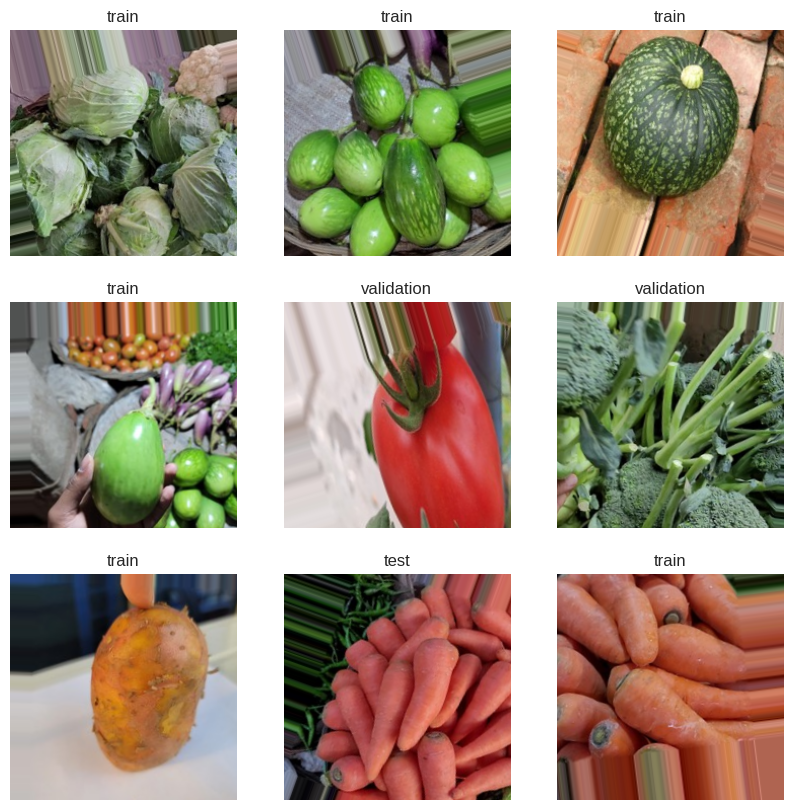

In [17]:
# Display sample images from the dataset
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training generator
images, labels = next(train_gen)

# Display a few images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    # Get the true label (one-hot encoded) and find the corresponding class name
    true_label_index = np.argmax(labels[i])
    plt.title(class_labels[true_label_index])
    plt.axis("off")
plt.show()

# **Build and Train MobileNetV2-Based Model**

In [5]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping to prevent overfitting and improve convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train for more epochs to improve accuracy
history = model.fit(train_gen, validation_data=val_gen, epochs=3, callbacks=[early_stopping])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
525/525 ━━━━━━━━━━━━━━━━━━━━ 1146s 2s/step - accuracy: 0.6180 - loss: 1.0050 - val_accuracy: 0.7033 - val_loss: 0.8737
Epoch 2/3
525/525 ━━━━━━━━━━━━━━━━━━━━ 1126s 2s/step - accuracy: 0.6817 - loss: 0.9062 - val_accuracy: 0.7086 - val_loss: 0.8658
Epoch 3/3
525/525 ━━━━━━━━━━━━━━━━━━━━ 1146s 2s/step - accuracy: 0.6882 - loss: 0.8909 - val_accuracy: 0.7110 - val_loss: 0.8555


# **Quantize Model for Edge Deployment**

In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save quantized model
with open('vegetable_model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)

print('[INFO] Quantized TFLite model saved as vegetable_model_quantized.tflite')

# Evaluate and Plot Performance
sns.set(style='whitegrid', context='talk')


Saved artifact at '/tmp/tmpho2756eh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136547075132304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075132688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075136144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075135760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075134608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075136336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075135376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075131728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075136528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136547075134416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13654707513691

In [7]:
# Compare original and quantized model metrics
import os

# Get original model size
original_size = os.path.getsize('vegetable_model_quantized.tflite') / (1024 * 1024)  # Size in MB

# Evaluate original model performance
original_eval = model.evaluate(val_gen)
original_accuracy = original_eval[1]

# Load and evaluate quantized model
interpreter = tf.lite.Interpreter(model_path='vegetable_model_quantized.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test quantized model on validation set
correct_predictions = 0
total_predictions = 0
quantized_inference_times = []

for i in range(min(50, len(val_gen))):  # Test on 50 batches or all if less
    x, y_true = next(val_gen)
    total_predictions += len(x)

    for j in range(len(x)):
        start_time = time.time()
        interpreter.set_tensor(input_details[0]['index'], x[j:j+1])
        interpreter.invoke()
        inference_time = time.time() - start_time
        quantized_inference_times.append(inference_time)

        output = interpreter.get_tensor(output_details[0]['index'])
        pred = np.argmax(output)
        true = np.argmax(y_true[j])
        if pred == true:
            correct_predictions += 1

quantized_accuracy = correct_predictions / total_predictions
avg_inference_time = np.mean(quantized_inference_times)

print("\nModel Comparison Metrics:")
print("-" * 50)
print(f"Original Model Size: {original_size:.2f} MB")
print(f"Original Model Accuracy: {original_accuracy:.4f}")
print(f"Quantized Model Accuracy: {quantized_accuracy:.4f}")
print(f"Average Inference Time (Quantized): {avg_inference_time*1000:.2f} ms")
print(f"Accuracy Drop After Quantization: {(original_accuracy - quantized_accuracy)*100:.2f}%")

132/132 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.7042 - loss: 0.8668

Model Comparison Metrics:
--------------------------------------------------
Original Model Size: 2.39 MB
Original Model Accuracy: 0.7067
Quantized Model Accuracy: 0.7194
Average Inference Time (Quantized): 26.73 ms
Accuracy Drop After Quantization: -1.27%


# **Plot accuracy and loss**

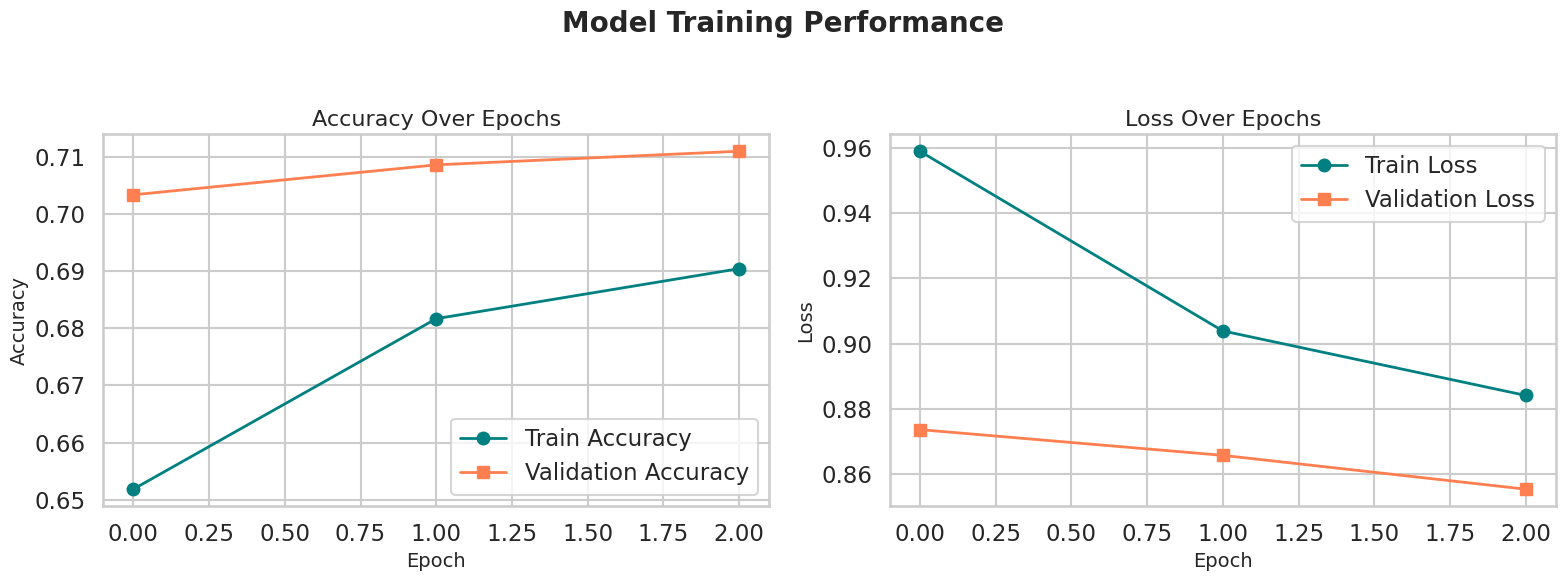

In [8]:
plt.figure(figsize=(16, 6))
plt.suptitle('Model Training Performance', fontsize=20, fontweight='bold')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color='teal', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', color='coral', linewidth=2)
plt.title('Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='teal', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', color='coral', linewidth=2)
plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step


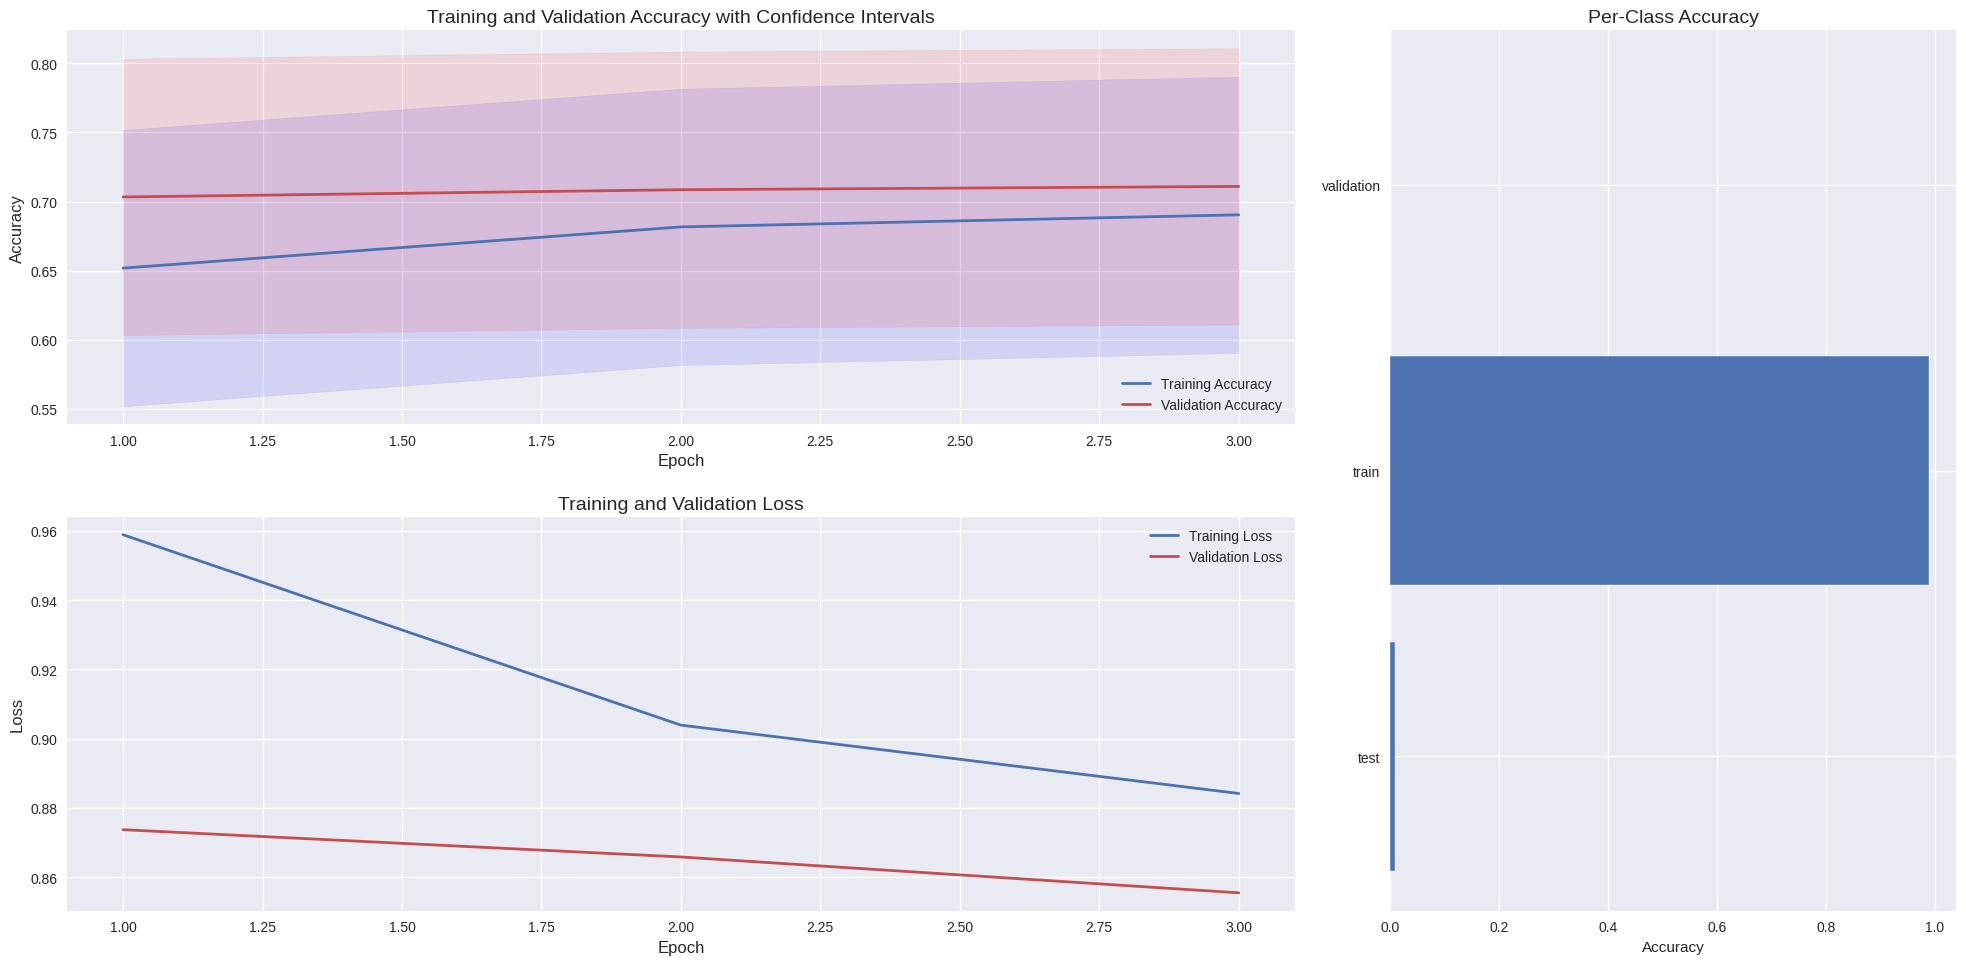


 Detailed Training Metrics Summary
--------------------------------------------------
Final Training Accuracy: 0.6904
Final Validation Accuracy: 0.7110
Final Training Loss: 0.8842
Final Validation Loss: 0.8555

Per-Class Accuracy:
test: 0.0083
train: 0.9900
validation: 0.0000


In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 10))

# Layout setup
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
ax3 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)

# Accuracy plot with confidence intervals
epochs = range(1, len(history.history['accuracy']) + 1)
ax1.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
ax1.fill_between(epochs,
                 np.array(history.history['accuracy']) - 0.1,
                 np.array(history.history['accuracy']) + 0.1,
                 alpha=0.1, color='blue')
ax1.fill_between(epochs,
                 np.array(history.history['val_accuracy']) - 0.1,
                 np.array(history.history['val_accuracy']) + 0.1,
                 alpha=0.1, color='red')
ax1.set_title('Training and Validation Accuracy with Confidence Intervals', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True)

# Loss plot
ax2.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Training and Validation Loss', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True)

# Class-wise accuracy plot
val_predictions = model.predict(val_gen)
predicted_classes = np.argmax(val_predictions, axis=1)

class_accuracies = []
true_labels = val_gen.labels  # Already 1D array of class indices

for i in range(len(class_labels)):
    true_class = true_labels == i
    pred_class = predicted_classes == i
    if np.sum(true_class) > 0:
        acc = np.sum(true_class & pred_class) / np.sum(true_class)
    else:
        acc = 0
    class_accuracies.append(acc)

# Plotting per-class accuracy
y_pos = np.arange(len(class_labels))
ax3.barh(y_pos, class_accuracies, align='center')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(class_labels)
ax3.set_xlabel('Accuracy')
ax3.set_title('Per-Class Accuracy', fontsize=14)

plt.tight_layout()
plt.show()

# Detailed summary printout
print("\n Detailed Training Metrics Summary")
print("-" * 50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("\nPer-Class Accuracy:")
for label, acc in zip(class_labels, class_accuracies):
    print(f"{label}: {acc:.4f}")

# **Generate confusion matrix**

Generating predictions for validation set...


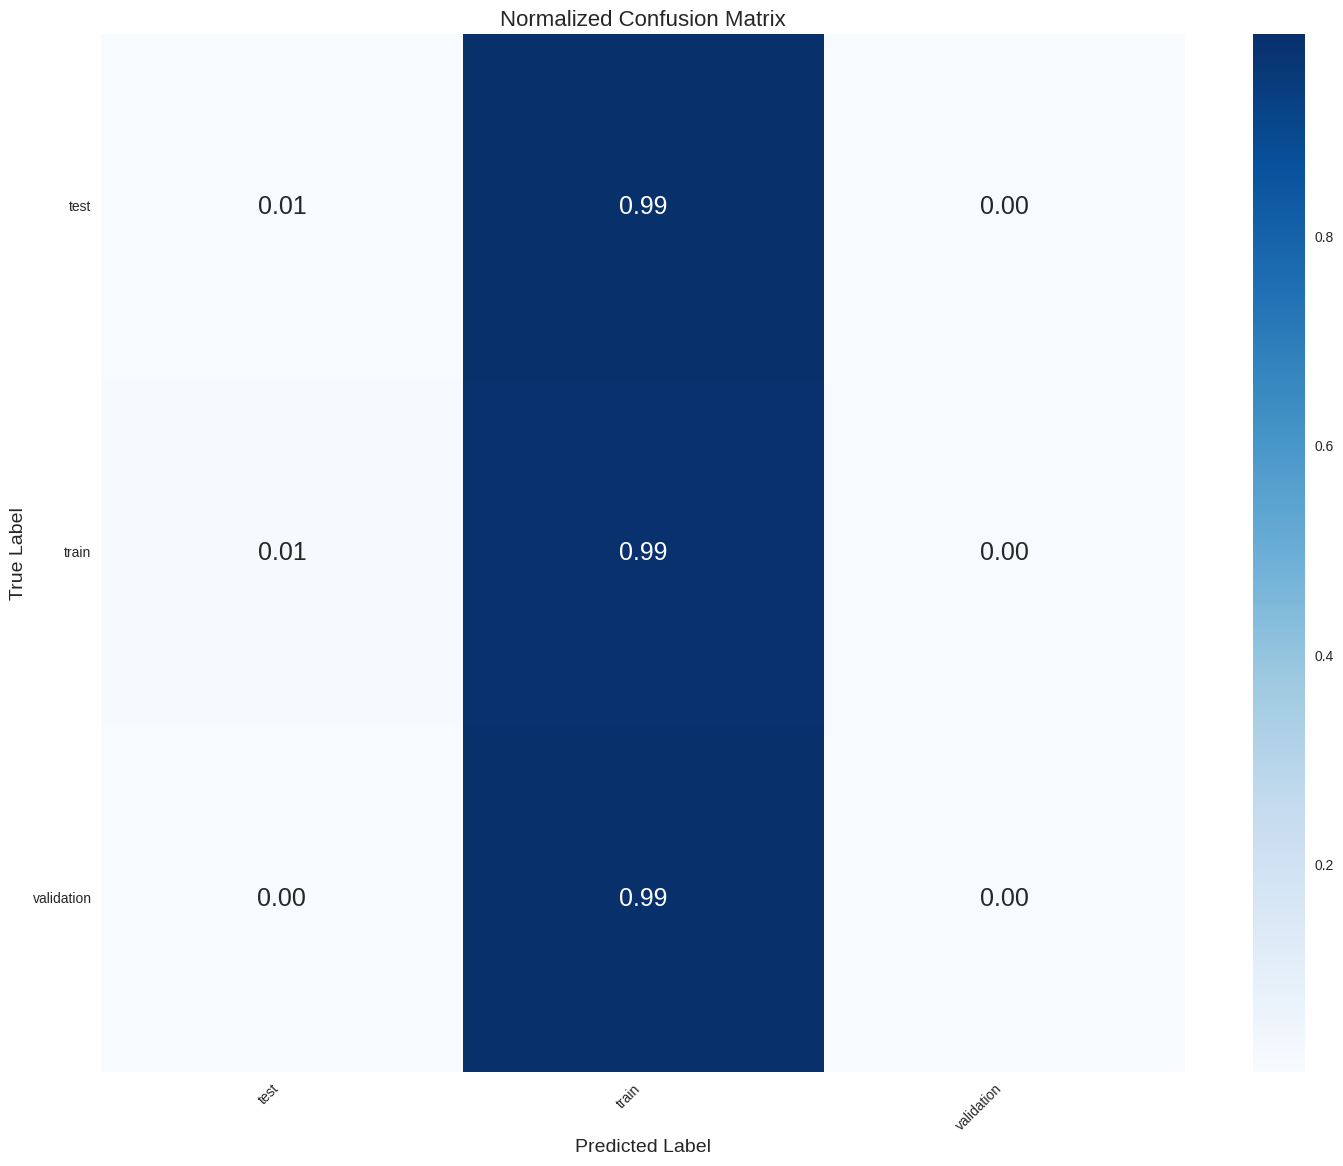


Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

        test       0.09      0.01      0.01       600
       train       0.71      0.99      0.83      3000
  validation       0.20      0.00      0.01       600

    accuracy                           0.71      4200
   macro avg       0.33      0.33      0.28      4200
weighted avg       0.55      0.71      0.59      4200


Confidence Statistics per Class:
--------------------------------------------------------------------------------
train:
  Average Confidence: 0.6680
  Min Confidence: 0.3565
  Max Confidence: 0.9362

validation:
  Average Confidence: 0.6722
  Min Confidence: 0.3787
  Max Confidence: 0.9376

test:
  Average Confidence: 0.6668
  Min Confidence: 0.3660
  Max Confidence: 0.9206



In [12]:
# Generate comprehensive test results and confusion matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Get predictions for the entire validation set
print("Generating predictions for validation set...")
val_gen.reset()
all_predictions = []
all_true_labels = []
test_confidences = []

for i in range(len(val_gen)):
    x, y = next(val_gen)
    pred = model.predict(x, verbose=0)
    all_predictions.extend(np.argmax(pred, axis=1))
    all_true_labels.extend(np.argmax(y, axis=1))
    test_confidences.extend(np.max(pred, axis=1))

# Calculate confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create enhanced visualization
plt.figure(figsize=(15, 12))

# Plot normalized confusion matrix
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDetailed Classification Report:")
print("-" * 80)
print(classification_report(all_true_labels, all_predictions, target_names=class_labels))

# Calculate and display confidence statistics per class
class_confidences = {}
for pred, conf, true_label in zip(all_predictions, test_confidences, all_true_labels):
    class_name = class_labels[true_label]
    if class_name not in class_confidences:
        class_confidences[class_name] = []
    class_confidences[class_name].append(conf)

print("\nConfidence Statistics per Class:")
print("-" * 80)
for class_name, confidences in class_confidences.items():
    conf_array = np.array(confidences)
    print(f"{class_name}:")
    print(f"  Average Confidence: {np.mean(conf_array):.4f}")
    print(f"  Min Confidence: {np.min(conf_array):.4f}")
    print(f"  Max Confidence: {np.max(conf_array):.4f}")
    print()

# **Test Model with Simulated Edge Inference**

In [16]:
mqtt_logs = []

def on_message_with_logging(client, userdata, msg):
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    log_entry = {
        'timestamp': timestamp,
        'topic': msg.topic,
        'payload': json.loads(msg.payload.decode())
    }
    mqtt_logs.append(log_entry)
    print(f"[{timestamp}] Received on {msg.topic}: {msg.payload.decode()}")

def visualize_mqtt_logs():
    if not mqtt_logs:
        print("No MQTT messages logged yet.")
        return

    plt.figure(figsize=(12, 6))

    # Extract confidence values and timestamps
    confidences = [log['payload']['confidence'] for log in mqtt_logs]
    timestamps = [log['timestamp'] for log in mqtt_logs]

    # Plot confidence over time
    plt.plot(range(len(confidences)), confidences, 'bo-', label='Prediction Confidence')
    plt.title('MQTT Message Confidence Over Time')
    plt.xlabel('Message Number')
    plt.ylabel('Confidence')
    plt.grid(True)
    plt.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(range(len(timestamps)), timestamps, rotation=45)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nMQTT Communication Summary:")
    print("-" * 50)
    print(f"Total messages sent: {len(mqtt_logs)}")
    print(f"Average confidence: {np.mean([log['payload']['confidence'] for log in mqtt_logs]):.4f}")
    print(f"Average inference time: {np.mean([log['payload']['inference_time'] for log in mqtt_logs]):.4f} seconds")

# Modify the client to use the new logging callback
client = mqtt.Client(protocol=mqtt.MQTTv5)
client.on_connect = on_connect
client.on_message = on_message_with_logging

# Test with multiple predictions
test_images = val_gen.filepaths[:5]  # Test with 5 images
print("\nTesting MQTT communication with multiple images:")
print("-" * 50)

for img_path in test_images:
    print(f"\nProcessing image: {os.path.basename(img_path)}")
    img_array = preprocess_image(img_path)
    predicted_label, confidence, inf_time = predict_image(interpreter, img_array, class_labels)
    publish_prediction(predicted_label, confidence, inf_time)
    time.sleep(1)  # Wait between predictions

# Visualize the MQTT communication results
visualize_mqtt_logs()

/tmp/ipython-input-16-3287288926.py:46: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client(protocol=mqtt.MQTTv5)
/tmp/ipython-input-15-1554408873.py:2: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client(protocol=mqtt.MQTTv5)



Testing MQTT communication with multiple images:
--------------------------------------------------

Processing image: 0001.jpg

Prediction Result
--------------------
Predicted Class : train
Confidence Score: 70.50%
Inference Time: 0.0277 seconds
[INFO] Published prediction: {"predicted_class": "train", "confidence": 0.7050159573554993, "inference_time": 0.027651071548461914}
[INFO] Connected to MQTT broker with code Connection rate exceeded

Processing image: 0002.jpg

Prediction Result
--------------------
Predicted Class : train
Confidence Score: 75.47%
Inference Time: 0.0245 seconds
[INFO] Published prediction: {"predicted_class": "train", "confidence": 0.7546528577804565, "inference_time": 0.024487018585205078}

Processing image: 0003.jpg

Prediction Result
--------------------
Predicted Class : train
Confidence Score: 63.51%
Inference Time: 0.0244 seconds
[INFO] Published prediction: {"predicted_class": "train", "confidence": 0.6351410746574402, "inference_time": 0.024355649948

# **MQTT Integration for Low-Latency Communication**

In [14]:
def on_connect(client, userdata, flags, rc, properties=None):
    print(f'[INFO] Connected to MQTT broker with code {rc}')
    client.subscribe('vegetable/predictions')

def on_message(client, userdata, msg):
    print(f'[INFO] Received message on {msg.topic}: {msg.payload.decode()}')

# **Simulate edge device sending prediction to server**

In [15]:
def publish_prediction(predicted_label, confidence, inference_time):
    client = mqtt.Client(protocol=mqtt.MQTTv5)
    client.on_connect = on_connect
    client.on_message = on_message

    # Connect to a public MQTT broker (e.g., HiveMQ)
    client.connect('broker.hivemq.com', 1883, 60)

    payload = json.dumps({
        'predicted_class': predicted_label,
        'confidence': float(confidence),
        'inference_time': inference_time
    })
    client.publish('vegetable/predictions', payload)
    print(f'[INFO] Published prediction: {payload}')
    client.loop_start()
    time.sleep(1)  # Allow time for message to be sent
    client.loop_stop()
    client.disconnect()

# Test MQTT with the last prediction
publish_prediction(predicted_label, confidence, inf_time)

/tmp/ipython-input-15-1554408873.py:2: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client(protocol=mqtt.MQTTv5)


[INFO] Published prediction: {"predicted_class": "train", "confidence": 0.6019984483718872, "inference_time": 0.02733755111694336}
[INFO] Connected to MQTT broker with code Success
